In [7]:
"""
Comprehensive Clustering and Dimensionality Reduction Analysis
Hospital Readmission Project - Track 5

Includes:
- K-Means, Hierarchical, DBSCAN clustering
- PCA, t-SNE, UMAP dimensionality reduction
- Cluster evaluation and profiling
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score,
    silhouette_samples
)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Try to import UMAP (optional)
try:
    from umap import UMAP
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️  UMAP not available. Install with: pip install umap-learn")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [9]:
# =========================
# 1. LOAD DATA
# =========================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv("data/diabetic_data.csv")
print(f"Dataset shape: {df.shape}")

LOADING DATA
Dataset shape: (101766, 50)


In [10]:
# =========================
# 2. FEATURE SELECTION
# =========================
print("\n" + "="*60)
print("FEATURE SELECTION FOR CLUSTERING")
print("="*60)

# Focus on features that define patient profiles
numeric_features = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses"
]

categorical_features = [
    "race",
    "gender",
    "age",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "max_glu_serum",
    "A1Cresult",
    "diabetesMed"
]

# Optional: medication features
medication_features = [
    "metformin", "repaglinide", "nateglinide", 
    "glimepiride", "glipizide", "glyburide", 
    "pioglitazone", "rosiglitazone", "insulin"
]

all_features = numeric_features + categorical_features + medication_features

print(f"Selected {len(all_features)} features")
print(f"  - Numeric: {len(numeric_features)}")
print(f"  - Categorical: {len(categorical_features)}")
print(f"  - Medications: {len(medication_features)}")

# Create working dataframe
df_cluster = df[all_features + ['readmitted', 'encounter_id']].copy()



FEATURE SELECTION FOR CLUSTERING
Selected 26 features
  - Numeric: 8
  - Categorical: 9
  - Medications: 9



PREPROCESSING
Total missing values: 0
Final dataset size: (101766, 50)

ENCODING FEATURES
Combined feature matrix: (101766, 26)

SCALING FEATURES
Scaled data shape: (101766, 26)

FINDING OPTIMAL NUMBER OF CLUSTERS

Evaluating different k values...
k=2: Silhouette=0.079, Davies-Bouldin=3.651, Calinski-Harabasz=6430.0
k=3: Silhouette=0.064, Davies-Bouldin=3.332, Calinski-Harabasz=5541.8
k=4: Silhouette=0.072, Davies-Bouldin=2.757, Calinski-Harabasz=5188.0
k=5: Silhouette=0.061, Davies-Bouldin=2.665, Calinski-Harabasz=4955.5
k=6: Silhouette=0.064, Davies-Bouldin=2.677, Calinski-Harabasz=4857.3
k=7: Silhouette=0.074, Davies-Bouldin=2.514, Calinski-Harabasz=4790.1
k=8: Silhouette=0.082, Davies-Bouldin=2.257, Calinski-Harabasz=4966.5
k=9: Silhouette=0.089, Davies-Bouldin=2.287, Calinski-Harabasz=4846.0
k=10: Silhouette=0.091, Davies-Bouldin=2.217, Calinski-Harabasz=4750.6


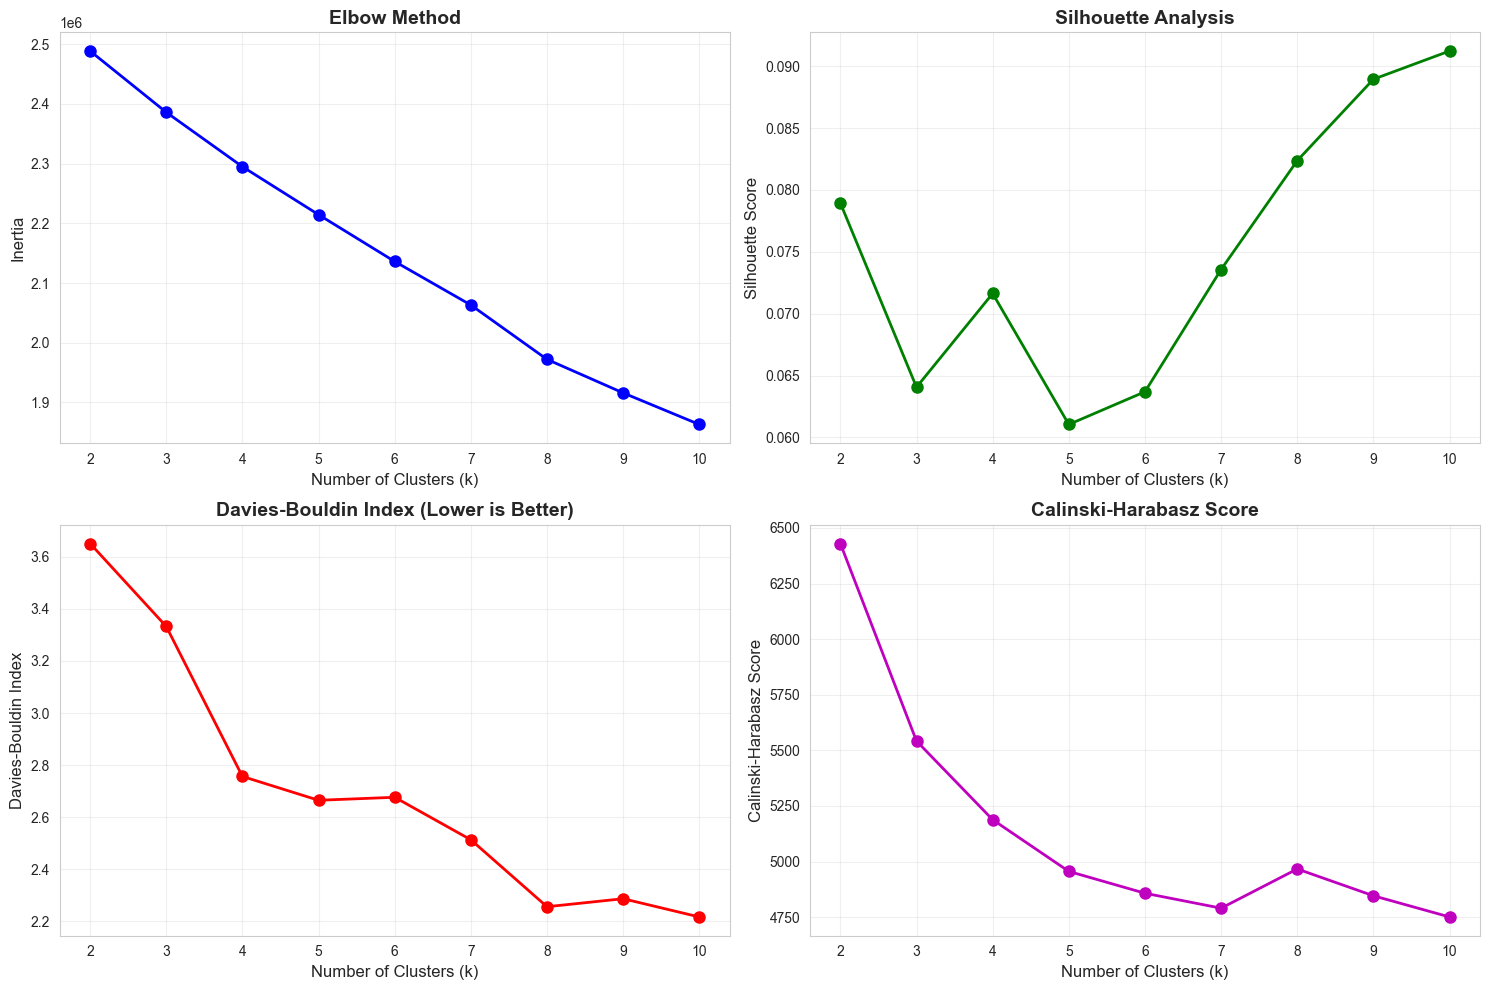


✅ Optimal k (by silhouette score): 10


In [13]:
# =========================
# 3. DATA PREPROCESSING
# =========================
print("\n" + "="*60)
print("PREPROCESSING")
print("="*60)

#df = df.drop(columns=["encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty"], axis=1)

for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# For numeric columns: convert safely and fill with mean
for col in df.select_dtypes(exclude='object').columns:
    df[col].fillna(df[col].mean(), inplace=True)

print("Total missing values:", df.isnull().sum().sum())


# CRITICAL FIX: Only drop rows with missing values in the SELECTED FEATURES
# Don't drop based on columns we're not using (like medical_specialty, payer_code, etc.)
features_to_check = numeric_features + categorical_features + medication_features
df = df.dropna(subset=features_to_check)

#print(f"\nDropped {initial_rows - len(df_cluster)} rows with missing values in selected features")
print(f"Final dataset size: {df.shape}")
#print(f"Retention rate: {len(df_cluster)/initial_rows*100:.1f}%")

# Separate features
X_numeric = df[numeric_features].copy()
X_categorical = df[categorical_features].copy()
X_medications = df[medication_features].copy()

# =========================
# 4. ENCODE CATEGORICAL FEATURES
# =========================
print("\n" + "="*60)
print("ENCODING FEATURES")
print("="*60)

# Label encoding
X_categorical_encoded = X_categorical.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col].astype(str))
    label_encoders[col] = le

X_medications_encoded = X_medications.copy()
for col in medication_features:
    le = LabelEncoder()
    X_medications_encoded[col] = le.fit_transform(X_medications[col].astype(str))
    label_encoders[col] = le

# Combine all features
X_combined = pd.concat([X_numeric, X_categorical_encoded, X_medications_encoded], axis=1)
print(f"Combined feature matrix: {X_combined.shape}")

# =========================
# 5. SCALE FEATURES
# =========================
print("\n" + "="*60)
print("SCALING FEATURES")
print("="*60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)
print(f"Scaled data shape: {X_scaled.shape}")

# =========================
# 6. FIND OPTIMAL NUMBER OF CLUSTERS
# =========================
print("\n" + "="*60)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_scores = []

print("\nEvaluating different k values...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.3f}, "
          f"Calinski-Harabasz={calinski_scores[-1]:.1f}")

# Plot evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow plot
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin index
axes[1, 0].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz score
axes[1, 1].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal k (by silhouette score): {optimal_k}")


In [16]:
# =========================
# 7. APPLY K-MEANS CLUSTERING
# =========================
print("\n" + "="*60)
print(f"APPLYING K-MEANS (k={optimal_k})")
print("="*60)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

df['kmeans_cluster'] = kmeans_labels

print(f"\nK-Means cluster distribution:")
print(df_cluster['kmeans_cluster'].value_counts().sort_index())
print(f"\nCluster percentages:")
print(df_cluster['kmeans_cluster'].value_counts(normalize=True).sort_index() * 100)


APPLYING K-MEANS (k=10)

K-Means cluster distribution:
kmeans_cluster
0     53
1    245
Name: count, dtype: int64

Cluster percentages:
kmeans_cluster
0    17.785235
1    82.214765
Name: proportion, dtype: float64


In [17]:
# =========================
# 8. APPLY HIERARCHICAL CLUSTERING
# =========================
print("\n" + "="*60)
print(f"APPLYING HIERARCHICAL CLUSTERING (k={optimal_k})")
print("="*60)

# Try different linkage methods
linkage_methods = ['ward', 'complete', 'average']
hierarchical_results = {}

for method in linkage_methods:
    hier = AgglomerativeClustering(n_clusters=optimal_k, linkage=method)
    hier_labels = hier.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, hier_labels)
    
    hierarchical_results[method] = {
        'labels': hier_labels,
        'silhouette': silhouette
    }
    
    print(f"Linkage: {method}, Silhouette: {silhouette:.3f}")

# Use best method
best_linkage = max(hierarchical_results, key=lambda x: hierarchical_results[x]['silhouette'])
hier_labels = hierarchical_results[best_linkage]['labels']

df['hierarchical_cluster'] = hier_labels

print(f"\n✅ Best linkage method: {best_linkage}")
print(f"\nHierarchical cluster distribution:")
print(df_cluster['hierarchical_cluster'].value_counts().sort_index())

# Create dendrogram (on sample for speed)
print("\nCreating dendrogram...")
sample_size = min(1000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

linkage_matrix = linkage(X_sample, method=best_linkage)

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title(f'Hierarchical Clustering Dendrogram ({best_linkage} linkage)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


APPLYING HIERARCHICAL CLUSTERING (k=10)


MemoryError: Unable to allocate 38.6 GiB for an array with shape (5178108495,) and data type float64

In [18]:
# =========================
# 9. APPLY DBSCAN
# =========================
print("\n" + "="*60)
print("APPLYING DBSCAN")
print("="*60)

# Test different eps values
eps_values = [0.5, 1.0, 1.5, 2.0]
dbscan_results = {}

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5, n_jobs=-1)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = np.sum(dbscan_labels == -1)
    
    dbscan_results[eps] = {
        'labels': dbscan_labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'pct_noise': n_noise / len(dbscan_labels) * 100
    }
    
    print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(dbscan_labels)*100:.1f}%)")

# Choose eps with reasonable noise level (5-10%)
optimal_eps = 1.5
dbscan_labels = dbscan_results[optimal_eps]['labels']

df['dbscan_cluster'] = dbscan_labels

print(f"\n✅ Using eps={optimal_eps}")
print(f"Clusters: {dbscan_results[optimal_eps]['n_clusters']}")
print(f"Noise points: {dbscan_results[optimal_eps]['n_noise']}")



APPLYING DBSCAN
eps=0.5: 77 clusters, 101086 noise points (99.3%)
eps=1.0: 364 clusters, 85225 noise points (83.7%)
eps=1.5: 359 clusters, 54801 noise points (53.9%)
eps=2.0: 330 clusters, 29482 noise points (29.0%)

✅ Using eps=1.5
Clusters: 359
Noise points: 54801



PCA DIMENSIONALITY REDUCTION


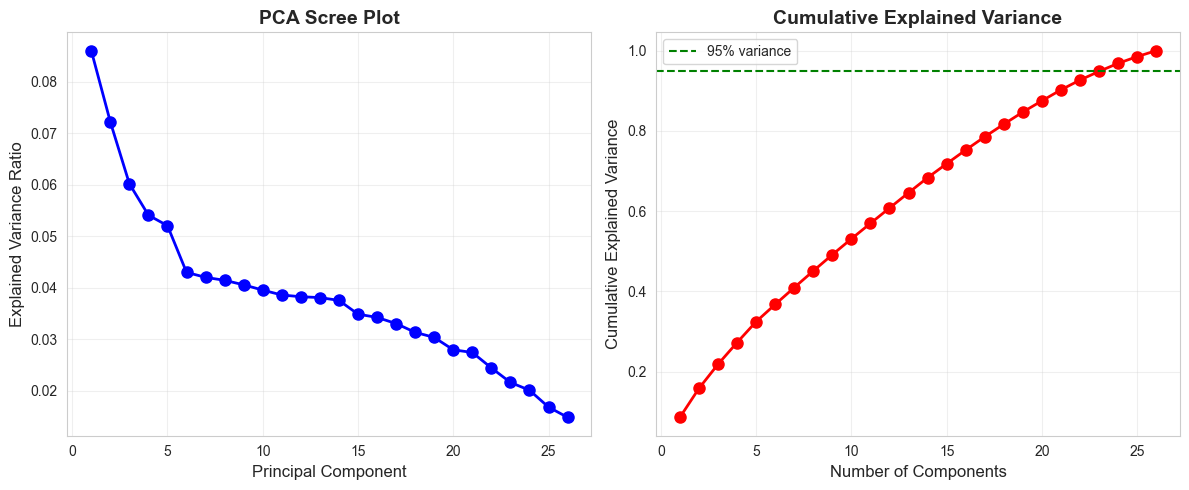


Components needed for 95% variance: 24
Top 10 components explain: 53.09% of variance


ValueError: Length of values (101766) does not match length of index (298)

In [20]:
# =========================
# 10. PCA DIMENSIONALITY REDUCTION
# =========================
print("\n" + "="*60)
print("PCA DIMENSIONALITY REDUCTION")
print("="*60)

# Full PCA to see variance explained
pca_full = PCA()
pca_full.fit(X_scaled)

# Plot explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('PCA Scree Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumsum) + 1), cumsum, 'ro-', linewidth=2, markersize=8)
plt.axhline(y=0.95, color='green', linestyle='--', label='95% variance')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Number of components for 95% variance
n_components_95 = np.argmax(cumsum >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}")
print(f"Top 10 components explain: {cumsum[9]:.2%} of variance")

# Apply PCA for visualization (2D and 3D)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

df_cluster['pca_1'] = X_pca_2d[:, 0]
df_cluster['pca_2'] = X_pca_2d[:, 1]

print(f"\n2D PCA explains: {pca_2d.explained_variance_ratio_.sum():.2%} of variance")
print(f"3D PCA explains: {pca_3d.explained_variance_ratio_.sum():.2%} of variance")

In [21]:
# =========================
# 11. t-SNE DIMENSIONALITY REDUCTION
# =========================
print("\n" + "="*60)
print("t-SNE DIMENSIONALITY REDUCTION")
print("="*60)

# t-SNE on sample (it's slow on large datasets)
sample_size_tsne = min(10000, len(X_scaled))
sample_indices_tsne = np.random.choice(len(X_scaled), sample_size_tsne, replace=False)
X_sample_tsne = X_scaled[sample_indices_tsne]
kmeans_sample = kmeans_labels[sample_indices_tsne]

print(f"Running t-SNE on {sample_size_tsne} samples...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sample_tsne)

print("✅ t-SNE complete")


t-SNE DIMENSIONALITY REDUCTION
Running t-SNE on 10000 samples...


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [ ]:
# =========================
# 12. UMAP DIMENSIONALITY REDUCTION (Optional)
# =========================
if UMAP_AVAILABLE:
    print("\n" + "="*60)
    print("UMAP DIMENSIONALITY REDUCTION")
    print("="*60)
    
    print(f"Running UMAP on {sample_size_tsne} samples...")
    
    umap = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = umap.fit_transform(X_sample_tsne)
    
    print("✅ UMAP complete")




UMAP DIMENSIONALITY REDUCTION
Running UMAP on 10000 samples...


In [ ]:
# =========================
# 13. VISUALIZE CLUSTERS WITH DIFFERENT METHODS
# =========================
print("\n" + "="*60)
print("VISUALIZING CLUSTERS")
print("="*60)

# PCA visualization with all three clustering methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
scatter1 = axes[0].scatter(df_cluster['pca_1'], df_cluster['pca_2'], 
                           c=df_cluster['kmeans_cluster'], 
                           cmap='tab10', alpha=0.6, s=20,
                           edgecolors='black', linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title(f'K-Means Clustering (k={optimal_k})', fontsize=13, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierarchical
scatter2 = axes[1].scatter(df_cluster['pca_1'], df_cluster['pca_2'], 
                           c=df_cluster['hierarchical_cluster'], 
                           cmap='tab10', alpha=0.6, s=20,
                           edgecolors='black', linewidth=0.3)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1].set_title(f'Hierarchical Clustering ({best_linkage})', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# DBSCAN
scatter3 = axes[2].scatter(df_cluster['pca_1'], df_cluster['pca_2'], 
                           c=df_cluster['dbscan_cluster'], 
                           cmap='tab10', alpha=0.6, s=20,
                           edgecolors='black', linewidth=0.3)
axes[2].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[2].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[2].set_title(f'DBSCAN (eps={optimal_eps})', fontsize=13, fontweight='bold')
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

# =========================
# 14. COMPARE DIMENSIONALITY REDUCTION METHODS
# =========================
print("\n" + "="*60)
print("COMPARING DIMENSIONALITY REDUCTION METHODS")
print("="*60)

n_plots = 3 if UMAP_AVAILABLE else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 2:
    axes = [axes[0], axes[1]]

# PCA
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=kmeans_labels, cmap='tab10', alpha=0.5, s=10)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('PCA', fontsize=13, fontweight='bold')

# t-SNE
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                           c=kmeans_sample, cmap='tab10', alpha=0.5, s=10)
axes[1].set_xlabel('t-SNE 1', fontsize=11)
axes[1].set_ylabel('t-SNE 2', fontsize=11)
axes[1].set_title(f't-SNE (n={sample_size_tsne})', fontsize=13, fontweight='bold')

# UMAP
if UMAP_AVAILABLE:
    scatter3 = axes[2].scatter(X_umap[:, 0], X_umap[:, 1], 
                               c=kmeans_sample, cmap='tab10', alpha=0.5, s=10)
    axes[2].set_xlabel('UMAP 1', fontsize=11)
    axes[2].set_ylabel('UMAP 2', fontsize=11)
    axes[2].set_title(f'UMAP (n={sample_size_tsne})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# =========================
# 15. 3D PCA VISUALIZATION
# =========================
print("\n" + "="*60)
print("3D PCA VISUALIZATION")
print("="*60)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=kmeans_labels, cmap='tab10', alpha=0.5, s=10)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=11)
ax.set_title('3D PCA Visualization of K-Means Clusters', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='Cluster', pad=0.1)
plt.tight_layout()
plt.show()

# =========================
# 16. CLUSTER PROFILING
# =========================
print("\n" + "="*60)
print("CLUSTER PROFILING (K-MEANS)")
print("="*60)

for cluster_id in range(optimal_k):
    cluster_data = df_cluster[df_cluster['kmeans_cluster'] == cluster_id]
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data)}, {len(cluster_data)/len(df_cluster)*100:.1f}%)")
    print(f"{'='*60}")
    
    # Numeric features
    print("\nNumeric Features:")
    for feat in numeric_features:
        mean_val = cluster_data[feat].mean()
        median_val = cluster_data[feat].median()
        print(f"  {feat}: mean={mean_val:.2f}, median={median_val:.2f}")
    
    # Readmission distribution
    print("\nReadmission Distribution:")
    readmit_dist = cluster_data['readmitted'].value_counts()
    for cat, count in readmit_dist.items():
        print(f"  {cat}: {count} ({count/len(cluster_data)*100:.1f}%)")

# =========================
# 17. CLUSTER COMPARISON HEATMAP
# =========================
print("\n" + "="*60)
print("CREATING CLUSTER HEATMAP")
print("="*60)

# Calculate cluster centers
cluster_centers = pd.DataFrame()
for cluster_id in range(optimal_k):
    cluster_data = df_cluster[df_cluster['kmeans_cluster'] == cluster_id]
    cluster_means = cluster_data[numeric_features].mean()
    cluster_centers[f'Cluster {cluster_id}'] = cluster_means

# Standardize for heatmap
cluster_centers_std = (cluster_centers - cluster_centers.mean(axis=1).values.reshape(-1, 1)) / cluster_centers.std(axis=1).values.reshape(-1, 1)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers_std, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, cbar_kws={'label': 'Standardized Value'},
            linewidths=0.5)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Cluster Centers Heatmap (Standardized)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# =========================
# 18. SILHOUETTE ANALYSIS
# =========================
print("\n" + "="*60)
print("SILHOUETTE ANALYSIS")
print("="*60)

silhouette_vals = silhouette_samples(X_scaled, kmeans_labels)

fig, ax = plt.subplots(figsize=(10, 7))

y_lower = 10
for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[kmeans_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(i / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title('Silhouette Analysis for K-Means Clustering', fontsize=14, fontweight='bold')

avg_silhouette = silhouette_score(X_scaled, kmeans_labels)
ax.axvline(x=avg_silhouette, color="red", linestyle="--", 
           label=f'Average Score: {avg_silhouette:.3f}')
ax.legend()
ax.set_yticks([])
ax.set_xlim([-0.1, 1])

plt.tight_layout()
plt.show()

print(f"Average Silhouette Score: {avg_silhouette:.3f}")

# =========================
# 19. SAVE RESULTS
# =========================
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save clustered data
# df_cluster.to_csv('data/processed/clustered_patients.csv', index=False)
# print("✅ Saved clustered data")

# Save cluster centers
# cluster_centers.to_csv('results/tables/cluster_centers.csv')
# print("✅ Saved cluster centers")

print("\n" + "="*60)
print("✨ CLUSTERING & DIMENSIONALITY REDUCTION COMPLETE!")
print("="*60)
print(f"\n📊 Summary:")
print(f"  - Optimal k: {optimal_k}")
print(f"  - K-Means Silhouette: {silhouette_score(X_scaled, kmeans_labels):.3f}")
print(f"  - Hierarchical Silhouette: {silhouette_score(X_scaled, hier_labels):.3f}")
print(f"  - DBSCAN clusters: {dbscan_results[optimal_eps]['n_clusters']}")
print(f"  - PCA (2D) variance: {pca_2d.explained_variance_ratio_.sum():.2%}")
print(f"  - Components for 95% variance: {n_components_95}")